# CT Image + Segmentation Images

CT Pixel Dimensions (mm): [0.9758117  0.97581184 4.987864  ]
CT Shape: [629 629 224]


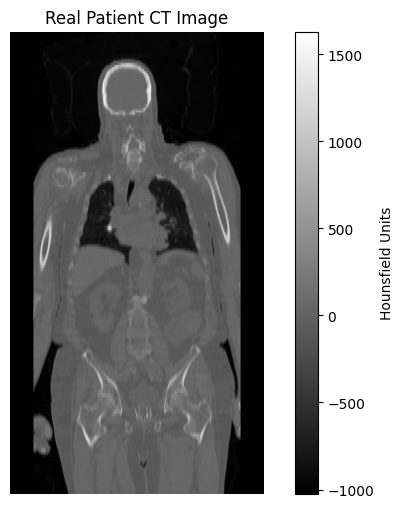

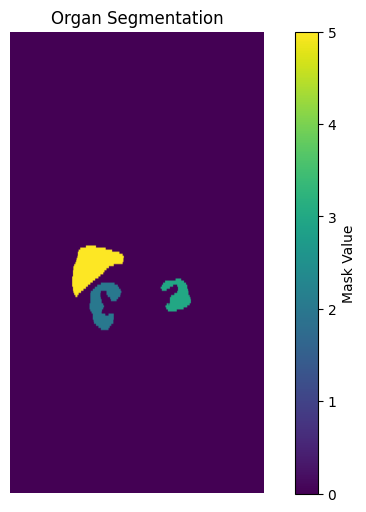

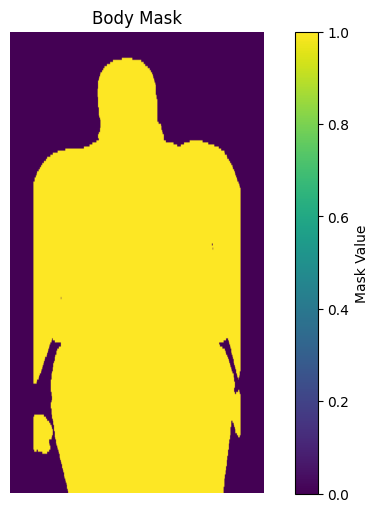

Shapes:
CT: (224, 629, 629)
Segmentation: (224, 629, 629)
Body mask: (224, 629, 629)


In [12]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib

def plot_medical_images(ct_path, ml_seg_path, body_seg_path, slice_idx=None):
    """Plot CT, segmentation and body mask separately with proper orientation"""
    
    ct = nib.load(ct_path)
    ct_pixel_dim = ct.header['pixdim'][1:4]
    ct_shape = ct.header['dim'][1:4]
    print(f"CT Pixel Dimensions (mm): {ct_pixel_dim}")
    print(f"CT Shape: {ct_shape}")
    
    # Load images
    ct_img = sitk.GetArrayFromImage(sitk.ReadImage(ct_path))
    ml_seg = sitk.GetArrayFromImage(sitk.ReadImage(ml_seg_path))
    body_seg = sitk.GetArrayFromImage(sitk.ReadImage(body_seg_path))
    
    if slice_idx is None:
        slice_idx = ct_img.shape[1] // 2
        
    # Plot CT
    plt.figure(figsize=(8, 6))
    im1 = plt.imshow(ct_img[:, slice_idx, :][::-1], cmap='gray', aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Real Patient CT Image')
    plt.colorbar(im1, label='Hounsfield Units')
    plt.axis('off')
    plt.show()
    
    # Plot ML segmentation
    plt.figure(figsize=(8, 6))
    im2 = plt.imshow(ml_seg[:, slice_idx, :][::-1],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Organ Segmentation')
    plt.colorbar(im2, label='Mask Value')
    plt.axis('off')
    plt.show()
    
    # Plot body segmentation
    plt.figure(figsize=(8, 6))
    im3 = plt.imshow(body_seg[:, slice_idx, :][::-1],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Body Mask')
    plt.colorbar(im3, label='Mask Value')
    plt.axis('off')
    plt.show()
    
    print("Shapes:")
    print(f"CT: {ct_img.shape}")
    print(f"Segmentation: {ml_seg.shape}")
    print(f"Body mask: {body_seg.shape}")
    
    return ct_img, ml_seg, body_seg

# Example usage
ct_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/TOTSEG_Outputs/TOTSEG_ct_input.nii.gz"
ml_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/TOTSEG_Outputs/TOTSEG_ml_segmentation.nii.gz"
body_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/TOTSEG_Outputs/TOTSEG_body_segmentation.nii.gz/body.nii.gz"

ct_vol, ml_seg_vol, body_seg_vol = plot_medical_images(ct_path, ml_seg_path, body_seg_path)

# PBPK - TACs

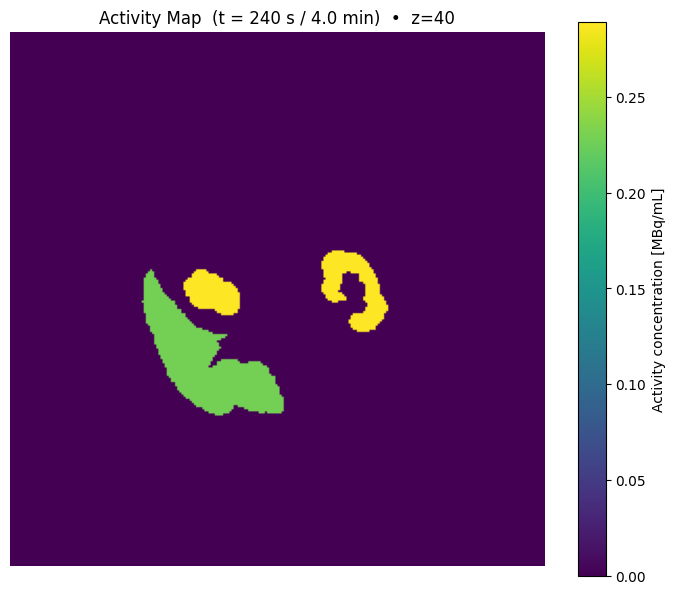

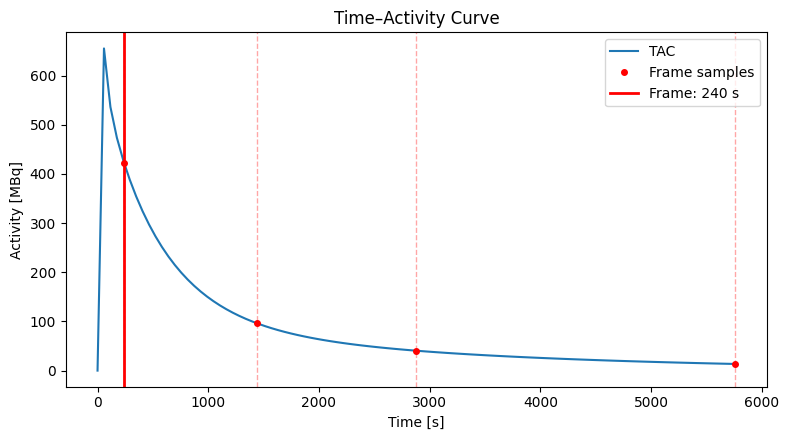

Time 4.0 min | shape (91, 256, 256) | max 2.89e-01 MBq/mL | mean 1.41e-03 MBq/mL


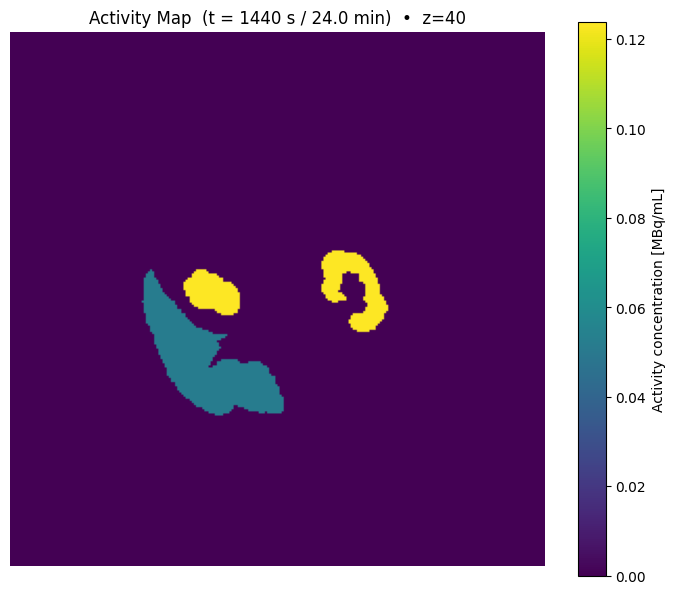

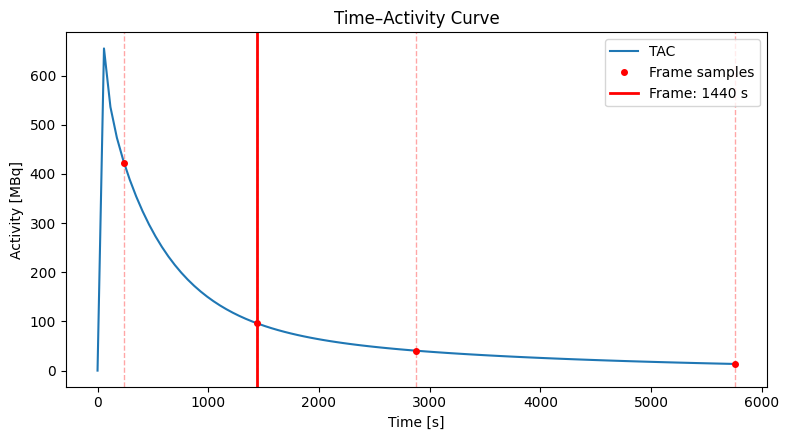

Time 24.0 min | shape (91, 256, 256) | max 1.24e-01 MBq/mL | mean 4.02e-04 MBq/mL


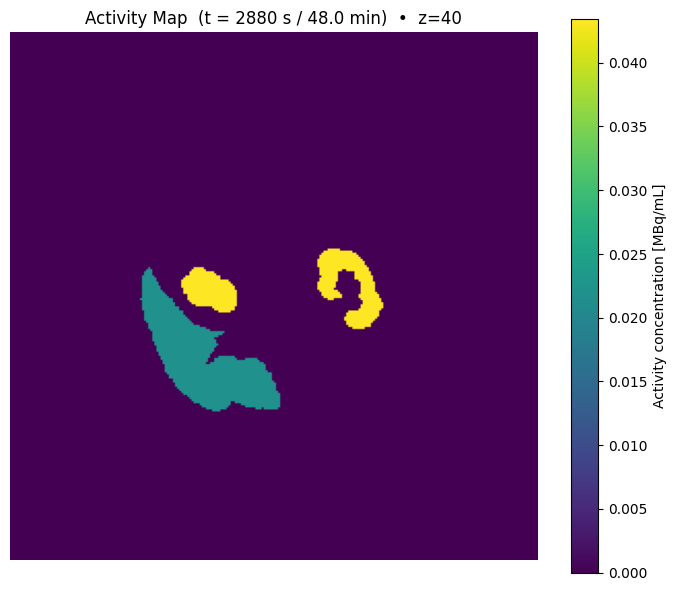

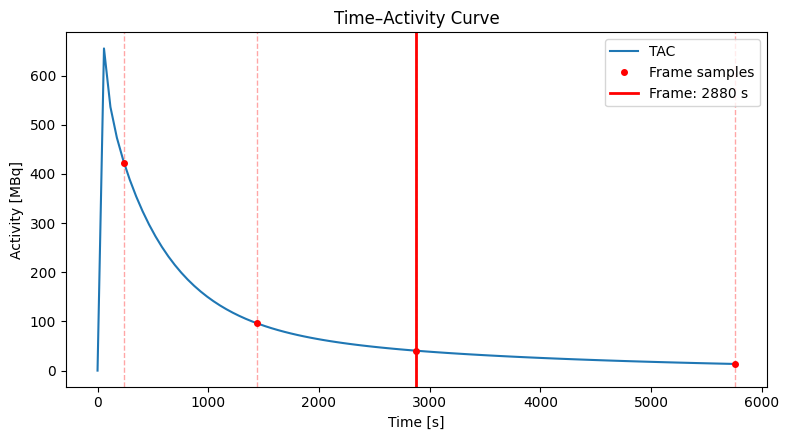

Time 48.0 min | shape (91, 256, 256) | max 4.34e-02 MBq/mL | mean 1.57e-04 MBq/mL


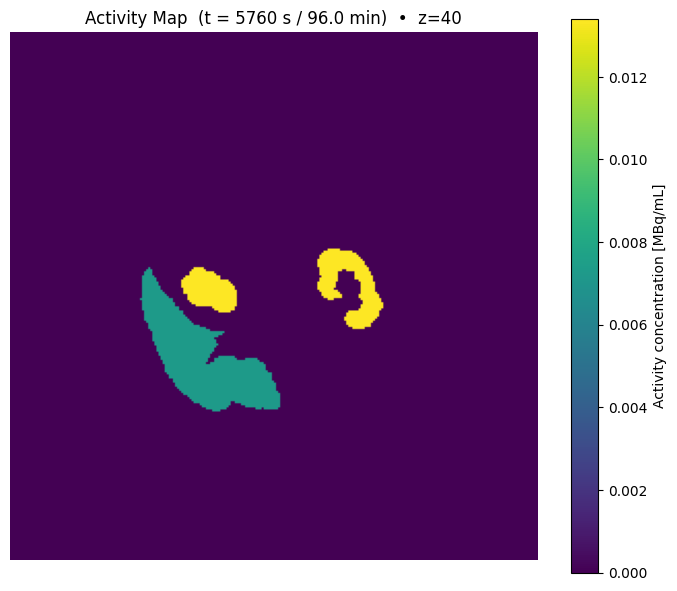

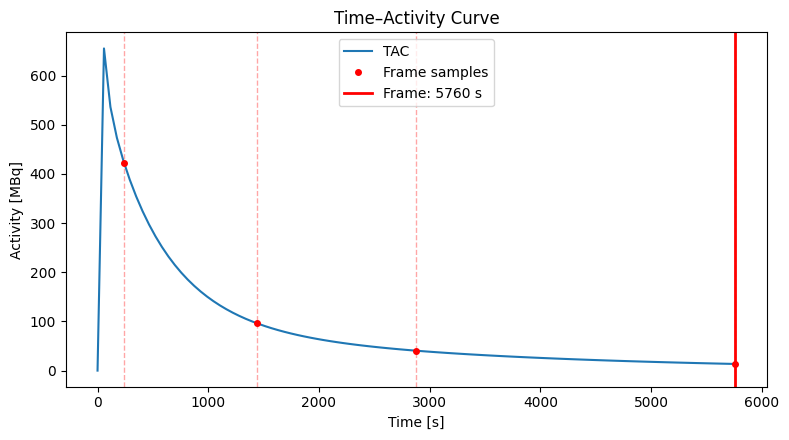

Time 96.0 min | shape (91, 256, 256) | max 1.34e-02 MBq/mL | mean 5.10e-05 MBq/mL


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_activity_map(file_path, time_s, z_index=40, volume_shape=(91, 256, 256), flip_y=True):
    """Load a single-frame activity map (float32 .bin), plot an axial slice."""
    arr = np.fromfile(file_path, dtype=np.float32).reshape(volume_shape)
    if flip_y:
        arr = arr[:, ::-1, :]  # match prior visualization
    plt.figure(figsize=(7, 6))
    im = plt.imshow(arr[z_index], origin="upper")
    plt.title(f"Activity Map  (t = {time_s:.0f} s / {time_s/60:.1f} min)  •  z={z_index}")
    cbar = plt.colorbar(im)
    cbar.set_label("Activity concentration [MBq/mL]")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    return arr

def plot_tac_with_frames(tac_time_f, tac_values_f, samp_time_f, samp_values_f, highlight_s=None):
    """Plot TAC and mark frame times with red dashed lines; optionally highlight one frame."""
    t  = np.fromfile(tac_time_f,    dtype=np.float32)
    y  = np.fromfile(tac_values_f,  dtype=np.float32)
    ts = np.fromfile(samp_time_f,   dtype=np.float32)
    ys = np.fromfile(samp_values_f, dtype=np.float32)

    plt.figure(figsize=(8, 4.5))
    plt.plot(t, y, label="TAC")
    plt.plot(ts, ys, "ro", markersize=4, label="Frame samples")
    for x in ts:
        plt.axvline(x, color="red", linestyle="--", alpha=0.35, linewidth=1.0)
    if highlight_s is not None:
        plt.axvline(highlight_s, color="red", linestyle="-", linewidth=2.0, label=f"Frame: {highlight_s:.0f} s")
    plt.xlabel("Time [s]")
    plt.ylabel("Activity [MBq]")
    plt.title("Time–Activity Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------- example usage --------------------
if __name__ == "__main__":
    base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/PBPK_Outputs"
    frame_times_s = [240, 1440, 2880, 5760]  # seconds
    frame_files = {t: os.path.join(base_path, f"PBPK_{t}_act_av.bin") for t in frame_times_s}

    # Optional: VOI TAC files (must match what you saved)
    pbpk_name = "PBPK"
    voi = "Liver"
    tac_time_f    = os.path.join(base_path, f"{pbpk_name}_{voi}_TAC_time.bin")
    tac_values_f  = os.path.join(base_path, f"{pbpk_name}_{voi}_TAC_values.bin")
    samp_time_f   = os.path.join(base_path, f"{pbpk_name}_{voi}_sample_times.bin")
    samp_values_f = os.path.join(base_path, f"{pbpk_name}_{voi}_sample_values.bin")
    have_tac = all(os.path.exists(p) for p in [tac_time_f, tac_values_f, samp_time_f, samp_values_f])

    activities = {}
    for time_s, path in frame_files.items():
        arr = plot_activity_map(path, time_s, z_index=40)
        activities[time_s] = arr
        if have_tac:
            plot_tac_with_frames(tac_time_f, tac_values_f, samp_time_f, samp_values_f, highlight_s=time_s)
        print(f"Time {time_s/60:.1f} min | shape {arr.shape} | max {np.max(arr):.2e} MBq/mL | mean {np.mean(arr):.2e} MBq/mL")


# PBPK - Acitvity Map

Shape at 240 min: (91, 256, 256)


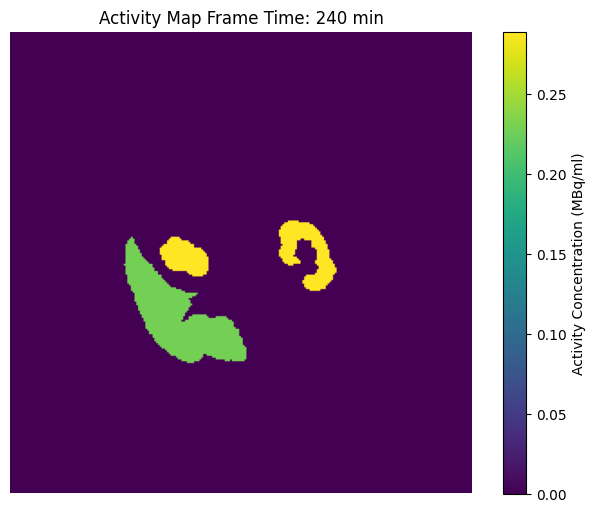

Shape at 1440 min: (91, 256, 256)


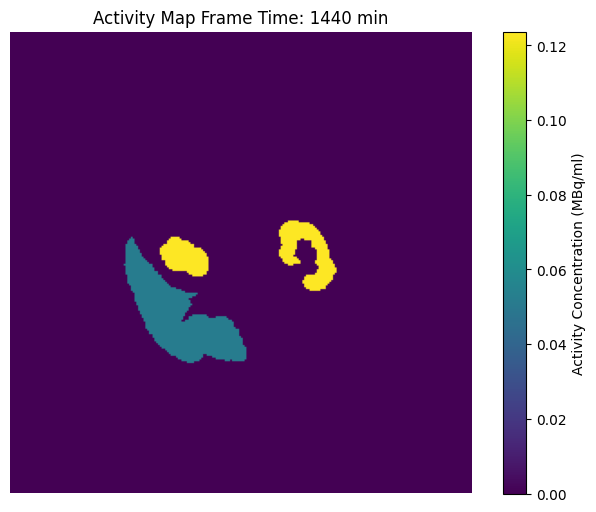

Shape at 2880 min: (91, 256, 256)


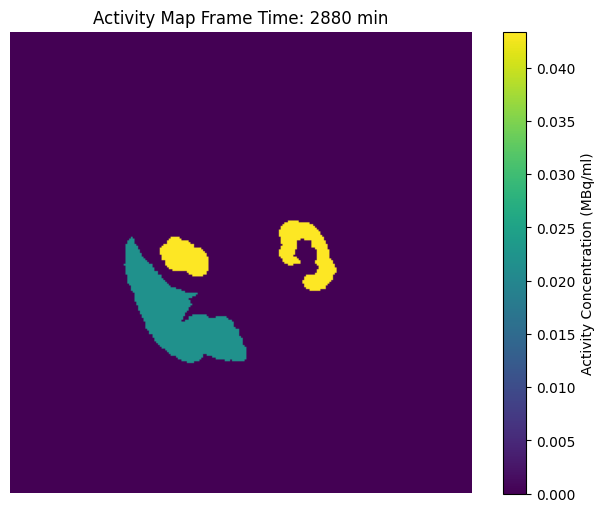

Shape at 5760 min: (91, 256, 256)


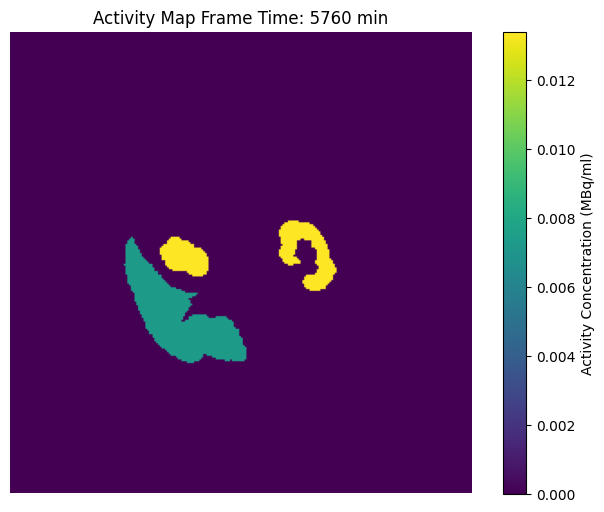


Time 240 min:
Max activity: 2.89e-01 MBq/ml
Mean activity: 1.41e-03 MBq/ml

Time 1440 min:
Max activity: 1.24e-01 MBq/ml
Mean activity: 4.02e-04 MBq/ml

Time 2880 min:
Max activity: 4.34e-02 MBq/ml
Mean activity: 1.57e-04 MBq/ml

Time 5760 min:
Max activity: 1.34e-02 MBq/ml
Mean activity: 5.10e-05 MBq/ml


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_activity_map(file_path, time_point):
    """Plot PBPK activity map for a given timepoint"""
    arr = np.fromfile(file_path, dtype=np.float32).reshape(91, 256, 256)[:,::-1]
    print(f"Shape at {time_point} min:", arr.shape)
    
    plt.figure(figsize=(8, 6))
    im = plt.imshow(arr[40,:,:])
    plt.title(f'Activity Map Frame Time: {time_point} min')
    plt.colorbar(im, label='Activity Concentration (MBq/ml)')
    plt.axis('off')
    plt.show()
    return arr

# File paths
base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/PBPK_Outputs"
times = [240, 1440, 2880, 5760]
files = {t: f"{base_path}/PBPK_{t}_act_av.bin" for t in times}

# Plot each timepoint
activities = {}
for time, path in files.items():
    activities[time] = plot_activity_map(path, time)

# Print statistics if needed
for time, arr in activities.items():
    print(f"\nTime {time} min:")
    print(f"Max activity: {np.max(arr):.2e} MBq/ml")
    print(f"Mean activity: {np.mean(arr):.2e} MBq/ml")

# SIMIND - Projections

Max value at 240 min: 4.85e+01


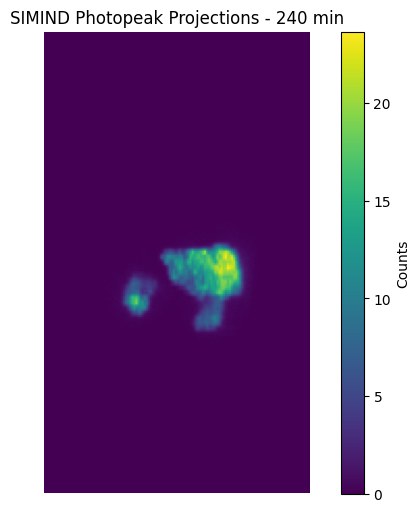

Max value at 1440 min: 1.11e+01


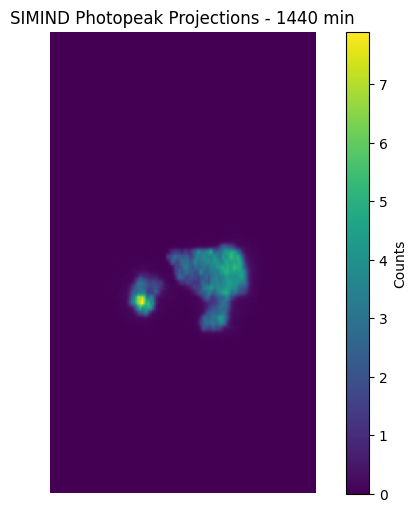

Max value at 2880 min: 4.66e+00


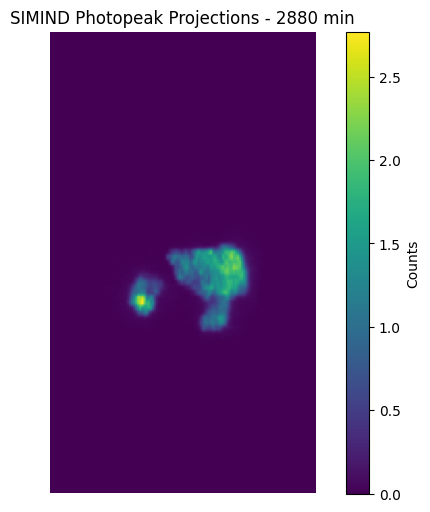

Max value at 5760 min: 1.56e+00


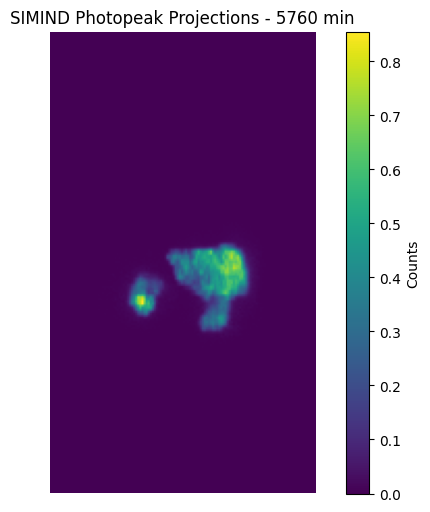

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_simind_projection(file_path, time_point):
    photopeak = np.fromfile(file_path, dtype=np.float32)
    projections = photopeak.reshape((64, 223, 128))
    
    # Plot projection
    plt.figure(figsize=(8, 6))
    im = plt.imshow(projections[0,:,:][:,::-1])
    plt.colorbar(im, label='Counts')
    plt.title(f'SIMIND Photopeak Projections - {time_point} min')
    print(f"Max value at {time_point} min: {np.max(projections):.2e}")
    plt.axis('off')
    plt.show()
    return projections

# File paths for each timepoint
base_path = "Output_Folder_CTvsSPECT_Comparison/SIMIND_Outputs"
paths = {
    240: f"{base_path}/simind_240min_tot_w2.a00",
    1440: f"{base_path}/simind_1440min_tot_w2.a00",
    2880: f"{base_path}/simind_2880min_tot_w2.a00",
    5760: f"{base_path}/simind_5760min_tot_w2.a00"
}

# Plot each timepoint
projections = {}
for time, path in paths.items():
    projections[time] = plot_simind_projection(path, time)

# RECON - SPECT IMAGE

Shape at 240 min: (223, 128, 128)


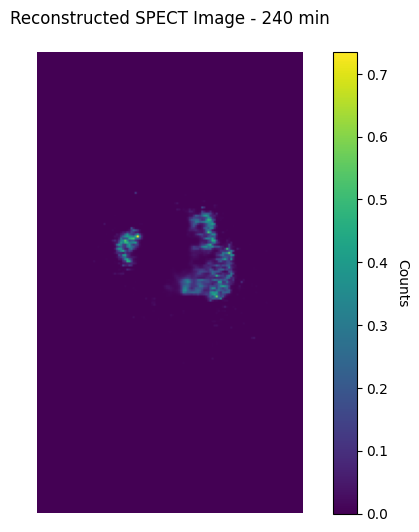

Max counts at 240 min: 1.10e+00

Shape at 1440 min: (223, 128, 128)


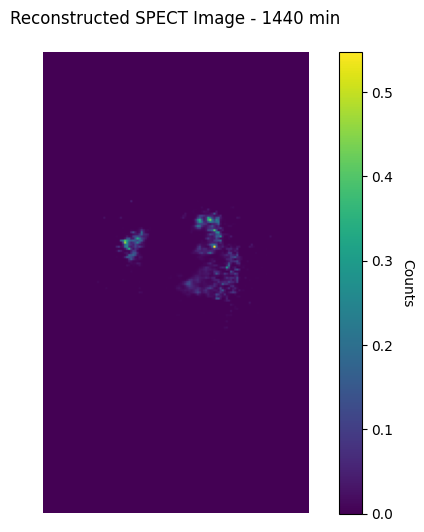

Max counts at 1440 min: 5.63e-01

Shape at 2880 min: (223, 128, 128)


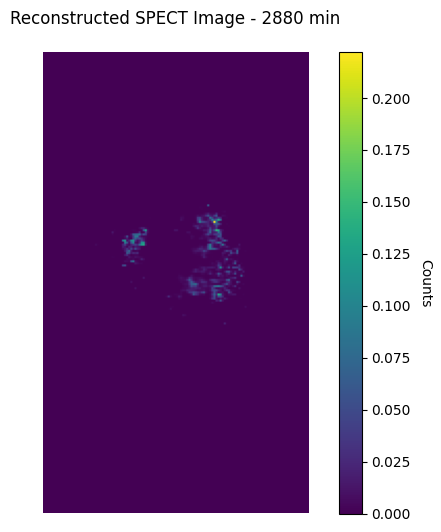

Max counts at 2880 min: 4.08e-01

Shape at 5760 min: (223, 128, 128)


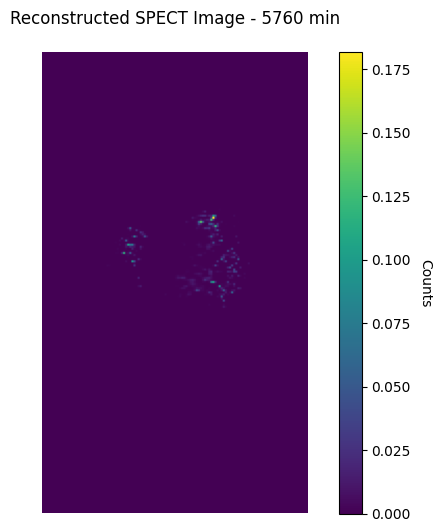

Max counts at 5760 min: 2.48e-01



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

def plot_recon_volume(file_path, time_point):
    """Plot a single reconstructed volume with improved formatting"""
    vol = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
    print(f"Shape at {time_point} min:", vol.shape)
    
    plt.figure(figsize=(8, 6))
    im = plt.imshow(vol[:, 60, :][:,::-1], cmap='viridis')
    plt.title(f'Reconstructed SPECT Image - {time_point} min', pad=20)
    cbar = plt.colorbar(im)
    cbar.set_label('Counts', rotation=270, labelpad=15)
    plt.axis('off')
    plt.show()
    print(f"Max counts at {time_point} min: {np.max(vol):.2e}\n")
    return vol

# Base path
base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/RECON_Outputs"

# Time points and corresponding files
times = [240, 1440, 2880, 5760]
volumes = {}

# Plot each timepoint
for i, time in enumerate(times):
    file_path = f"{base_path}/RECON_frame{i}.nii"
    volumes[time] = plot_recon_volume(file_path, time)

    

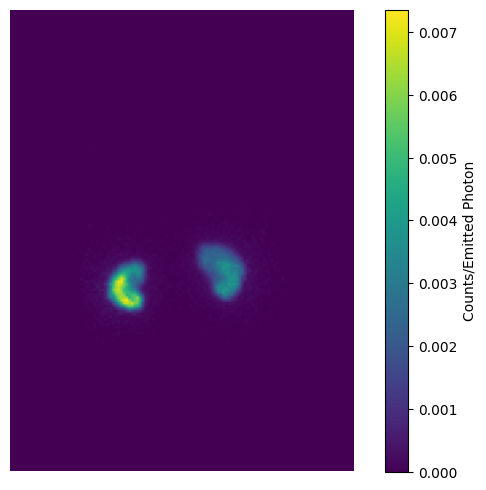

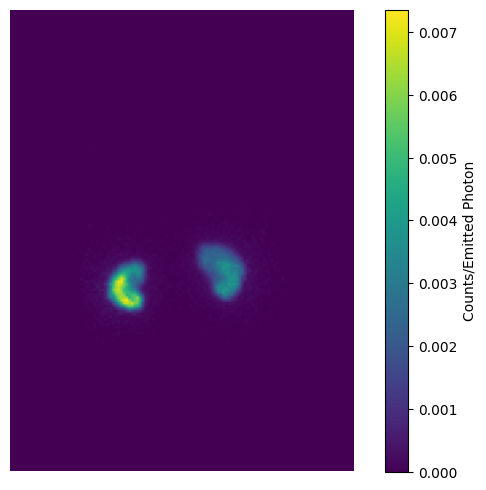

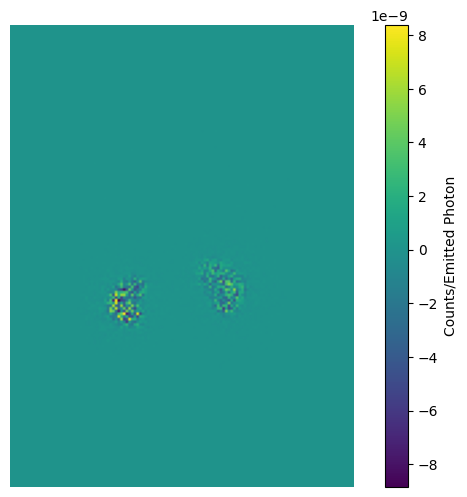

In [21]:
import numpy as np
import matplotlib.pyplot as plt

file_path1 = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Optimize/SIMIND_Outputs/simind_kidney_111_tot_w2.a00'


photopeak = np.fromfile(file_path1, dtype=np.float32)
projections1 = photopeak.reshape((64, 172, 128))

# Plot projection
plt.figure(figsize=(8, 6))
im = plt.imshow(projections1[0,:,:][:,::-1])
plt.colorbar(im, label='Counts/Emitted Photon')
plt.axis('off')
plt.show()

file_path2 = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Optimize/SIMIND_Outputs/simind_kidney_tot_w2.a00'


photopeak = np.fromfile(file_path2, dtype=np.float32)
projections2 = photopeak.reshape((64, 172, 128))

# Plot projection
plt.figure(figsize=(8, 6))
im = plt.imshow(projections2[0,:,:][:,::-1])
plt.colorbar(im, label='Counts/Emitted Photon')
plt.axis('off')
plt.show()




projections3 = projections1-projections2

# Plot projection
plt.figure(figsize=(8, 6))
im = plt.imshow(projections3[0,:,:][:,::-1])
plt.colorbar(im, label='Counts/Emitted Photon')
plt.axis('off')
plt.show()

